<a href="https://colab.research.google.com/github/nafrielramadhan/clustering/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://drive.google.com/uc?id=1f1gGVI-rxcHjA90WEGNvvtSXF1pAxQwg" alt="Fasilkom UI" width="300"/>

CSGE603130 • Kecerdasan Artifisial dan Sains Data Dasar

Fakultas Ilmu Komputer, Universitas Indonesia

Questions answered by: Muhammad Nafriel Ramadhan
##**Topic: Unsupervised Learning (Clustering)**

</center>

## Import Library

In [ ]:
# Impor library dan modul yang dibutuhkan pada tugas ini (boleh ditambahkan jika kurang)
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.cm as cm
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

from sklearn.decomposition import PCA

## Intro to Clustering
Clustering merupakan bagian dari unsupervised learning. Proses yang dilakukan adalah mengelompokkan data points ke dalam beberapa grup/klaster. Harapannya adalah objek pada klaster yang sama akan memiliki similarity yang tinggi. Sebaliknya, objek yang berada di klaster berbeda akan memiliki similarity yang rendah. Berbeda dengan supervised learning yang datanya sudah memiliki label yang bersesuaian, algoritma clustering tidak secara eksplisit menjelaskan makna tiap klaster. Oleh karena itu, tiap-tiap klaster tersebut perlu diinterpretasikan sendiri.

Algoritma clustering yang akan digunakan untuk lab ini adalah **K-Means** dan **Hierarchical** atau Agglomerative clustering. Berikut adalah penjelasan singkat mengenai keduanya:
1) **K-Means** membagi data menjadi K kluster di mana setiap titik data termasuk dalam kluster dengan pusat yang terdekat. Tujuan utamanya adalah untuk mengurangi variasi dalam kluster dan memaksimalkan variasi antara kluster.
2) **Hierarchical Clustering** membangun hirarki kluster dengan menggabungkan atau membagi kluster dalam langkah-langkah yang berurutan. Ini menghasilkan pohon kluster yang dapat diwakili sebagai dendrogram, yang memungkinkan analisis tingkat hierarki.

Mari kita lihat penerapan clustering menggunakan Scikit-Learn.

### K-Means Clustering

**Penjelasan Dataset**

| Atribut              | Penjelasan                                |
|--------------------- |-------------------------------------------|
| marital_status | Status pernikahan |
| income               | Pendapatan tahunan (USD)        |
| num_store_purchases  | Jumlah pembelian melalui toko offline     |
> Dataset merupakan adaptasi dan modifikasi dari https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis dan Lab 9 KASDD Genap 22/23

In [ ]:
# Load dataset
df = pd.read_csv('data_pelanggan_supermarket2.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,income,num_store_purchases,marital_status
0,58138.0,4,Single
1,46344.0,2,Single
2,71613.0,10,Together
3,26646.0,4,Together
4,58293.0,6,Married


In [ ]:
print(f"Ukuran dataset: {df.shape}")

Ukuran dataset: (500, 3)


In [ ]:
# Melihat informasi dasar dari dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   income               500 non-null    float64
 1   num_store_purchases  500 non-null    int64  
 2   marital_status       500 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 11.8+ KB


In [ ]:
# Melihat deskripsi statistik dasar dari kolom
df.describe()

,income,num_store_purchases
count,500.000000,500.000000
mean,51387.664000,5.800000
std,21245.949246,3.306034
min,2447.000000,0.000000
25%,34284.000000,3.000000
50%,50898.000000,5.000000
75%,67320.000000,8.000000
max,157243.000000,13.000000


Pada tahap ini, kita bisa melakukan imputasi data yang kosong, menghilangkan duplikat, dan menghapus outlier. Namun, hal ini tidak perlu kita lakukan pada dataset ini karena dataset tersebut sudah bersih.

Hal yang perlu dilakukan selanjutnya adalah melakukan standarisasi dan encoding kolom kategorikal.

In [ ]:
# Melakukan Standarisasi
from sklearn.preprocessing import StandardScaler

numerical_attributes = ['income', 'num_store_purchases']

df_std = pd.DataFrame(StandardScaler().fit_transform(df[numerical_attributes]), columns=numerical_attributes)
df_std['marital_status'] = df['marital_status']  # Membiarkan dulu atribut kategorikal
df_std.head()

,income,num_store_purchases,marital_status
0,0.318042,-0.545004,Single
1,-0.237632,-1.150565,Single
2,0.952915,1.271677,Together
3,-1.165702,-0.545004,Together
4,0.325344,0.060556,Married


In [ ]:
# Melakukan Encoding
print(f"Jumlah label unik dari marital status: {df['marital_status'].nunique()}")
print(f"{df['marital_status'].unique()}\n")

Jumlah label unik dari marital status: 6
['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone']



In [ ]:
pip install --upgrade category_encoders

In [ ]:
from category_encoders import OrdinalEncoder

marital_map =[{'col': 'marital_status',
             'mapping':{'Single': 1,
                        'Alone': 1,
                        'Together': 2,
                        'Married': 3,
                        'Divorced': 4,
                        'Widow': 5,}
            }]

enc2 = OrdinalEncoder(mapping=marital_map)
df_enc = enc2.fit_transform(df_std)

df_enc.head()

,income,num_store_purchases,marital_status
0,0.318042,-0.545004,1
1,-0.237632,-1.150565,1
2,0.952915,1.271677,2
3,-1.165702,-0.545004,2
4,0.325344,0.060556,3


**Persiapan Clustering**<br>
Selanjutnya, kita harus menentukan nilai K sebagai input dari algoritma K-means. **Silhouette Coefficient** merupakan salah satu metrik umum untuk mengevaluasi data yang tidak memiliki *true cluster*. Silhouette Coefficient menghitung rata-rata jarak intra-cluster dan minimum rata-rata jarak inter-cluster.


In [ ]:
# Menghitung Silhouette Coeff
for k in [2, 3, 4, 5]:
    # Mendefinisikan model K-Means dengan nilai k tertentu
    clusterer = KMeans(n_clusters = k, n_init=10)

    # Menghitung sihouette_score untuk mengukur seberapa baik klaster yang terbentuk.
    cluster_labels = clusterer.fit_predict(df_enc)
    silhouette_avg = silhouette_score(df_enc, cluster_labels)
    print(f"Untuk k = {k}, rata-rata silhouette_coefficient adalah: {silhouette_avg}")

Untuk k = 2, rata-rata silhouette_coefficient adalah: 0.38807169772444033
Untuk k = 3, rata-rata silhouette_coefficient adalah: 0.3728268092814725
Untuk k = 4, rata-rata silhouette_coefficient adalah: 0.3666925447292704
Untuk k = 5, rata-rata silhouette_coefficient adalah: 0.3615470682224549


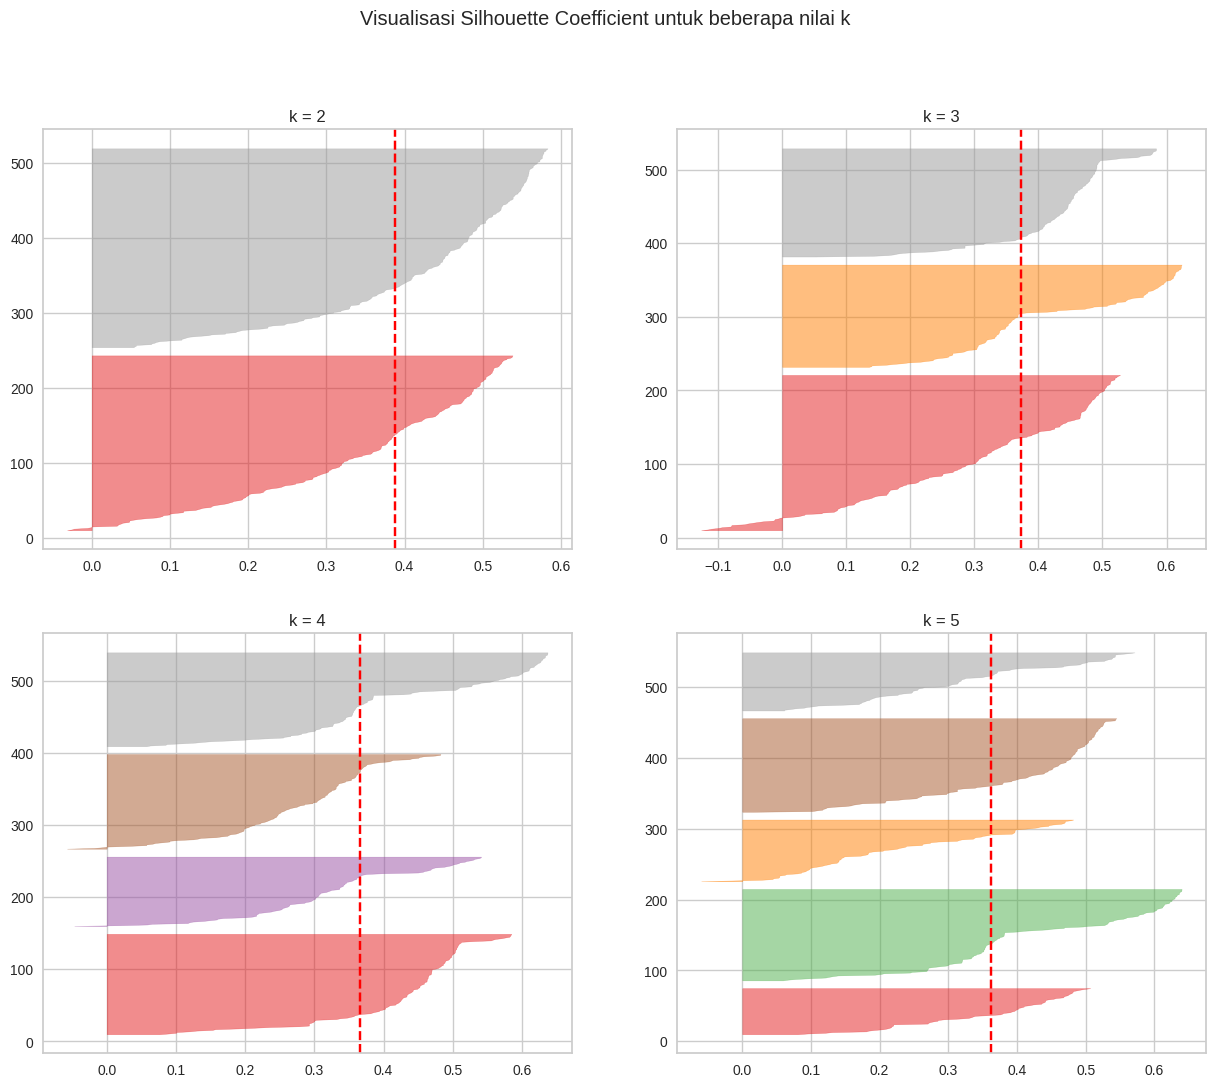

In [ ]:
# Memvisualisasikan silhouette

fig, ax = plt.subplots(2, 2, figsize=(15,12))
fig.suptitle("Visualisasi Silhouette Coefficient untuk beberapa nilai k")
for k in [2, 3, 4, 5]:
    # Mendefinisikan model K-Means dengan nilai k tertentu
    clusterer = KMeans(n_clusters=k, n_init=10)

    # Memvisualisasikan densitas tiap klaster yang terbentuk
    q, mod = divmod(k, 2)
    ax[q-1][mod].set_title(f"k = {k}")
    visualizer = SilhouetteVisualizer(clusterer, ax = ax[q-1][mod])
    visualizer.fit(df_enc)

**Metrik Pendukung**
Metrik lain yang juga menjadi acuan untuk menentukan jumlah klaster adalah **Elbow Method**. Cara kerjanya adalah menampilkan plot inersia di berbagai nilai k yang menunjukkan seberapa baik klaster yang dihasilkan terhadap datanya. Pada nilai k yang tepat, akan muncul suatu "inflection point" di mana terjadi perubahan drastis pada gradien kurva.

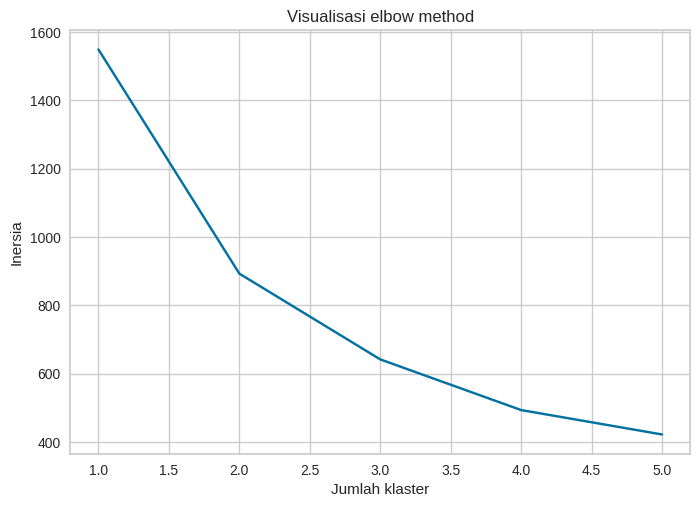

In [ ]:
# Memvisualisasikan elbow method
inertia = []
for cluster in range(1, 6):
    km = KMeans(n_clusters=cluster, n_init=10)
    km = km.fit(df_enc)
    inertia.append(km.inertia_)

plt.plot(range(1, 6), inertia, 'bx-')
plt.xlabel('Jumlah klaster')
plt.ylabel('Inersia')
plt.title('Visualisasi elbow method')
plt.show()

Berdasarkan hasil metrik Silhouette Coeff. dan Elbow Method, data ini tidak menghasilkan klaster yang baik. Nilai $s(C)$ untuk `k = 2`, `k = 3`, `k = 4`, dan `k = 5` tidak jauh berbeda. Hal ini juga dibuktikan dari plot Elbow Method di atas: tidak ada inflection point yang perubahan gradiennya cukup drastis. Nilai K yang dipilih adalah `k = 2` karena nilai $s(C)$ untuk `k = 2` merupakan yang paling tinggi. Selain itu, perubahan gradien inersia di sebelah kiri `k = 2` paling drastis di antara keempat kandidat klaster

**Train Model**<br>
Latih model KMeans dengan memilih parameter cluster berdasarkan nilai k yang dipilih.

In [ ]:
# Latih model sesuai jumlah klaster optimal
kmeans = KMeans(n_clusters=2, n_init=10)
assignment = kmeans.fit_predict(df_enc)

In [ ]:
# Append hasil clustering ke dataframe
df_with_clusters = pd.DataFrame(df_enc.copy())
df_with_clusters['cluster'] = assignment
df_with_clusters.head()

,income,num_store_purchases,marital_status,cluster
0,0.318042,-0.545004,1,1
1,-0.237632,-1.150565,1,1
2,0.952915,1.271677,2,0
3,-1.165702,-0.545004,2,1
4,0.325344,0.060556,3,0


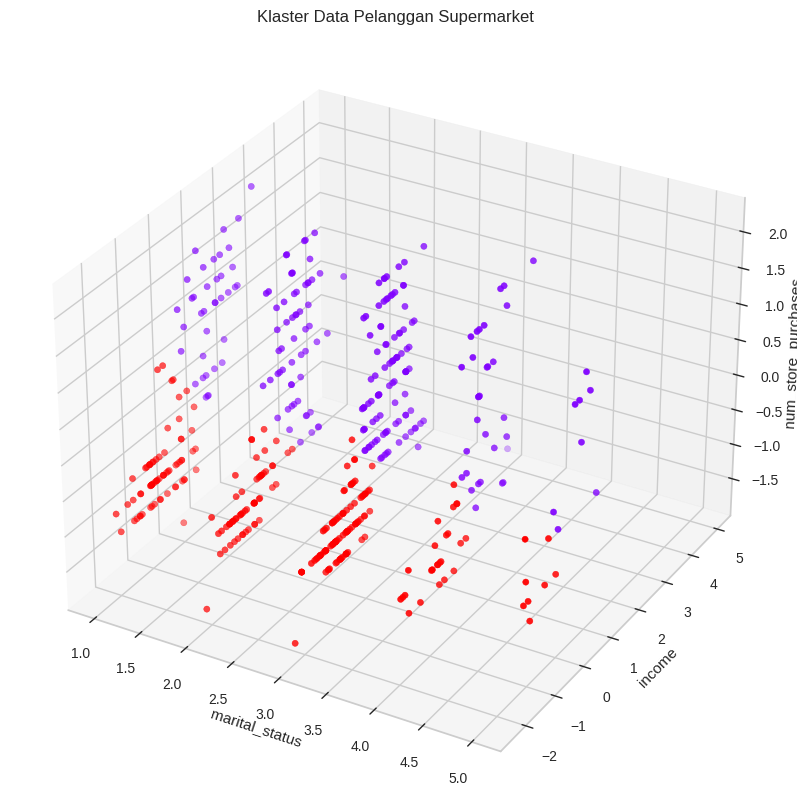

In [ ]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection="3d")

# Menyiapkan beberapa variabel yang diperlukan untuk visualisasi
x = df_with_clusters['marital_status']
y = df_with_clusters['income']
z = df_with_clusters['num_store_purchases']
cluster = df_with_clusters['cluster']

# Memvisualisasikan hasilnya
ax.scatter(x, y, z, c = cluster, cmap = "rainbow")
plt.title("Klaster Data Pelanggan Supermarket")
plt.grid(False)
ax.set_xlabel('marital_status')
ax.set_ylabel('income')
ax.set_zlabel('num_store_purchases')

plt.show()

> **Contoh interpretasi hasil**: Pada tiap kelas `marital_status` terdapat kedua jenis cluster, sehingga kelas `marital_status` tidak menentukan clustering secara signifikan. Di sisi lain, pola yang terlihat adalah cluster ungu selalu berada di kiri cluster merah. Ini menandakan bahwa atribut `income` merupakan pemisah utama. Cluster merah juga memiliki `num_store_purchases` yang lebih merata dibandingkan cluster ungu yang kebanyakan di bawah.

### Hierarchical (Agglomerative) Clustering
Berbeda dengan KMeans yang menentukan jumlah klaster kemudian mengevaluasinya, Agglomerative clustering mencari garis vertikal terpanjang yang menunjukkan pemisahan yang baik antara klaster yang terbentuk. Sebelum mengembangkan model untuk memprediksi klaster dari data, langkah pertama adalah menentukan jumlah klaster optimal berdasarkan visualisasi dendrogram.

Kita akan menggunakan dataset yang sama (`df_enc`) untuk pembuatan clustering hierarchical ini.

In [ ]:
# Membuat model sementara untuk divisualisasikan
agglomerative  = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
cluster_assignment = agglomerative.fit(df_enc)

# Menampilkan label klaster tiap data points
cluster_assignment.labels_

array([307, 438, 499, 260, 342, 429, 367, 305, 497, 323, 310, 496, 357,
       421, 387, 295, 341, 493, 253, 451, 414, 495, 287, 435, 447, 266,
       368, 315, 280, 345, 351, 490, 316, 352, 296, 330, 376, 303, 349,
       445, 489, 401, 482, 249, 453, 491, 247, 263, 284, 293, 275, 257,
       297, 407, 424, 391, 397, 392, 462, 309, 255, 432, 365, 369, 317,
       418, 325, 413, 420, 422, 354, 416, 439, 476, 463, 264, 277, 466,
       443, 360, 436, 372, 474, 340, 302, 460, 409, 477, 398, 427, 198,
       175, 483, 390, 444, 492, 379, 262, 488, 380, 370, 389, 294, 465,
       415, 374, 411, 343, 478, 346, 431, 333, 417, 259, 450, 271, 308,
       258, 327, 467, 366, 322, 378, 400, 291, 388, 232, 468, 487, 375,
       383, 425, 441, 254, 464, 210, 326, 452, 217, 381, 384, 486, 243,
       162, 412, 290, 471, 475, 498, 406, 300, 473, 328, 157, 481, 449,
       371, 324, 225, 289, 184, 386, 183, 244, 448, 428, 359, 278, 399,
       306, 182, 238, 131, 298, 461, 208, 265, 240, 470, 394, 18

In [ ]:
# Fungsi untuk menampilkan dendogram
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot dendogram yang dihasilkan
    shc.dendrogram(linkage_matrix, **kwargs)

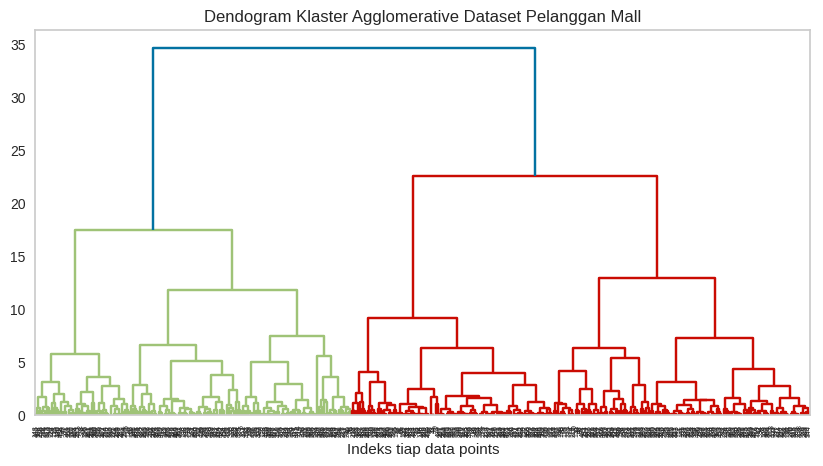

In [ ]:
plt.figure(figsize=(10, 5))
plt.grid(False)
plot_dendrogram(agglomerative, truncate_mode=None)
plt.title("Dendogram Klaster Agglomerative Dataset Pelanggan Mall")
plt.xlabel("Indeks tiap data points")
plt.show()

Secara rule-of-thumb, garis biru merupakan jumlah k yang optimal. Namun, berdasarkan dendogram yang dibentuk, data ini tidak menghasilkan klaster yang baik: panjang garis biru dan merah sebenarnya tidak jauh berbeda. Idealnya, garis biru akan jauh lebih panjang daripada garis-garis lainnya dan kita akan lebih mudah membuat batas threshold seperti di bawah ini.

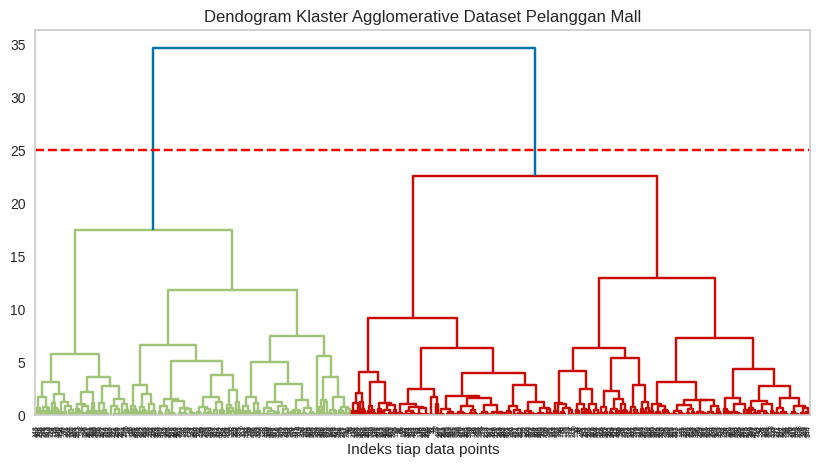

In [ ]:
plt.figure(figsize=(10, 5))
plt.grid(False)
plot_dendrogram(agglomerative, truncate_mode=None)
plt.title("Dendogram Klaster Agglomerative Dataset Pelanggan Mall")
plt.xlabel("Indeks tiap data points")
plt.axhline(y = 25, color = 'red', linestyle = 'dashed')
plt.show()

Selanjutnya, kita bisa membuat model Agglomerative Clustering dengan nilai k yang didapatkan sebelumnya. Setelah itu, visualisasikan hasil modelnya.

In [ ]:
# Definisikan model dengan hasil visualisasi sebelumnya
agglomerative = AgglomerativeClustering(n_clusters=2)
cluster_assignment2 = agglomerative.fit_predict(df_enc)

In [ ]:
# Append hasil clustering ke dataframe
df_with_clusters_agg = pd.DataFrame(df_enc.copy())
df_with_clusters_agg['cluster'] = cluster_assignment2
df_with_clusters_agg.head()

,income,num_store_purchases,marital_status,cluster
0,0.318042,-0.545004,1,0
1,-0.237632,-1.150565,1,0
2,0.952915,1.271677,2,1
3,-1.165702,-0.545004,2,0
4,0.325344,0.060556,3,1


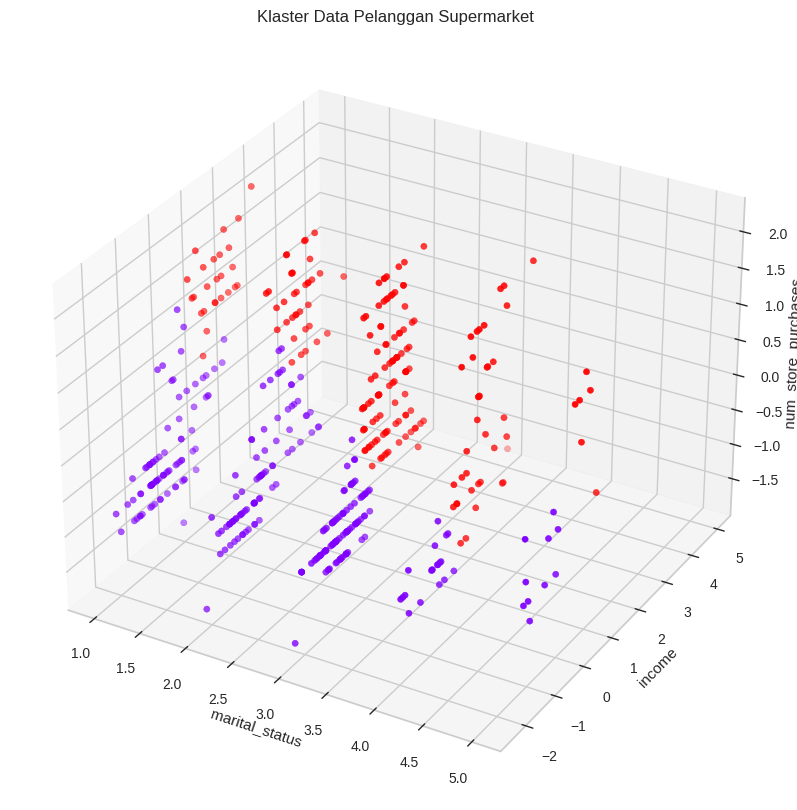

In [ ]:
# Melakukan visualisasi
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection="3d")

x = df_with_clusters_agg['marital_status']
y = df_with_clusters_agg['income']
z = df_with_clusters_agg['num_store_purchases']
cluster = df_with_clusters_agg['cluster']

ax.scatter(x, y, z, c = cluster, cmap = "rainbow")
plt.title("Klaster Data Pelanggan Supermarket")
plt.grid(False)
ax.set_xlabel('marital_status')
ax.set_ylabel('income')
ax.set_zlabel('num_store_purchases')

plt.show()

## Latihan Clustering
### Deskripsi Dataset

| Atribut              | Penjelasan                                |
|--------------------- |-------------------------------------------|
| CUST_ID                    | ID pelanggan (Kategorikal)                 |
| BALANCE              | Saldo rekening pelanggan                |
| BALANCE_FREQUENCY  | Seberapa sering saldonya ter-update (1 = sering, 0 tidak) |
| PURCHASES                | Jumlah total pembelian        |
| ONEOFF_PURCHASES                | Jumlah pembelian maksimum        |
| INSTALLMENTS_PURCHASES                | Jumlah pembelian untuk kredit       |
| CASH_ADVANCE   | Uang tunai yang diberikan oleh pengguna        |
| PURCHASES_FREQUENCY  | Seberapa sering Pembelian dilakukan, skor antara 0 dan 1 (1 = sering dibeli, 0 = jarang dibeli)   |
| ONEOFFPURCHASESFREQUENCY  | Seberapa sering Pembelian dilakukan dalam satu kali transaksi (1 = sering dibeli, 0 = jarang dibeli)   |
| PURCHASESINSTALLMENTSFREQUENCY   | Seberapa sering pembelian dalam angsuran dilakukan (1 = sering dilakukan, 0 = jarang dilakukan) |
| CASHADVANCEFREQUENCY   | Seberapa sering uang tunai di muka dibayar   |
| CASHADVANCETRX   | Jumlah Transaksi yang dilakukan dengan CASH_ADVANCE   |
| PURCHASES_TRX     | Jumlah transaksi pembelian yang dilakukan              |
| CREDIT_LIMIT     | Batas Kartu Kredit untuk pengguna              |
| PAYMENTS   | Jumlah Pembayaran yang dilakukan oleh pengguna    |
| MINIMUM_PAYMENTS   | Jumlah pembayaran minimum yang dilakukan oleh pengguna  |
| PRCFULLPAYMENT   | Persentase pembayaran penuh yang dibayarkan oleh pengguna   |
| TENURE   | Masa pelayanan kartu kredit bagi pengguna |
> Data diambil dari [https://www.kaggle.com/datasets/arjunbhasin2013/ccdata](https://www.kaggle.com/datasets/arjunbhasin2013/ccdata)

In [ ]:
# Load dataset
df = pd.read_csv('CC GENERAL.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [ ]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


### Soal 1: Preprocess Dataset

a) Pada tahap preprocessing dataset, persiapan yang dilakukan setidaknya perlu melakukan hal berikut:
- Mengecek dan menangani *missing values* dan data duplikat
- Menangani *outlier*
- Melakukan standarisasi
- Melakukan encoding pada atribut kategorikal

b) Jelaskan metode standarisasi yang dipilih beserta alasan (dan referensinya jika ada)

In [ ]:
# cek missing value
df.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

terdapat 1 missing value pada atribut credit_limit dan 313 missing value pada atribut minimum_payments.

In [ ]:
# Menghitung nilai skew (kemiringan) dari kolom 'CREDIT_LIMIT' dan 'MINIMUM_PAYMENTS' untuk menentukan metode untuk handle missing value
skew_credit_limit = df['CREDIT_LIMIT'].skew()
skew_minimum_payments = df['MINIMUM_PAYMENTS'].skew()

skew_credit_limit, skew_minimum_payments


(1.5224640052886198, 13.622796994677456)

karena nilai skew-nya tinggi, maka kita mengisi missing value dengan nilai median.

In [ ]:
# Mengisi missing value dengan median
df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].median(), inplace=True)
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)

# Memastikan tidak ada nilai yang hilang lagi
missing_values_after = df.isna().sum()
missing_values_after

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

missing value sudah tidak ada.

In [ ]:
# cek data duplikat
df.duplicated().sum()

0

tidak ada data duplikat.

In [ ]:
# Menghapus kolom 'CUST_ID' karena tidak berguna untuk clustering
df.drop(columns=['CUST_ID'], inplace=True)

# Menampilkan kolom yang tersisa untuk memastikan kolom 'CUST_ID' telah dihapus
df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [ ]:
# Mengecek outlier
import numpy as np

# Menghitung IQR, Lower Bound, dan Upper Bound
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
LB = Q1 - (1.5 * IQR)
UB = Q3 + (1.5 * IQR)

jumlah_outlier = []

# Menampilkan banyaknya outlier pada atribut
for col in df.select_dtypes(np.number).columns:
    outliers = ((df[col] < LB[col]) | (df[col] > UB[col])).sum()
    persentase_outliers = (outliers / len(df)) * 100
    jumlah_outlier.append([col, outliers, persentase_outliers])

# Membuat DataFrame untuk menampilkan hasil
outlier_df = pd.DataFrame(jumlah_outlier, columns=['Column', 'Jumlah Outlier', 'Persentase'])
outlier_df = outlier_df.sort_values(by=['Persentase'], ascending=False, ignore_index=True)
outlier_df


,Column,Jumlah Outlier,Persentase
0,BALANCE_FREQUENCY,1493,16.681564
1,PRC_FULL_PAYMENT,1474,16.469274
2,TENURE,1366,15.262570
3,CASH_ADVANCE,1030,11.508380
4,ONEOFF_PURCHASES,1013,11.318436
5,MINIMUM_PAYMENTS,909,10.156425
6,INSTALLMENTS_PURCHASES,867,9.687151
7,PAYMENTS,808,9.027933
8,PURCHASES,808,9.027933
9,CASH_ADVANCE_TRX,804,8.983240


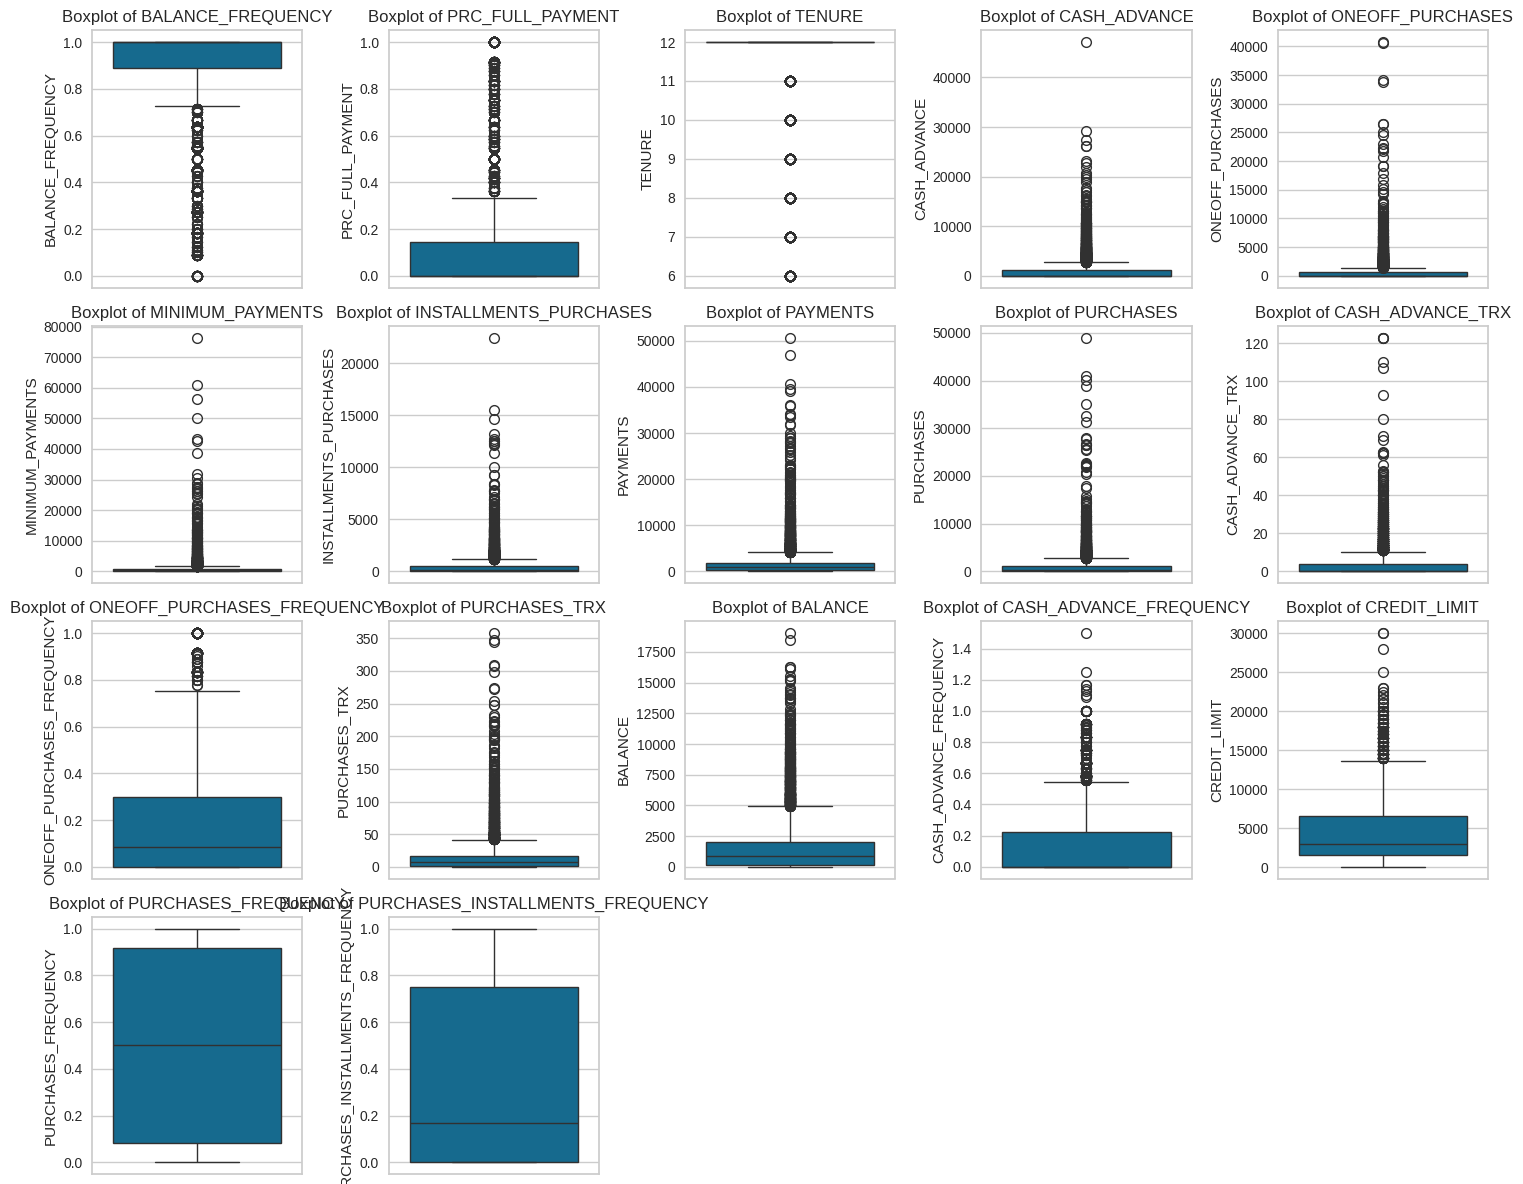

In [ ]:
# Membuat boxplot untuk kolom-kolom yang diperiksa
plt.figure(figsize=(15, 12))
for i, column in enumerate(outlier_df['Column'], 1):
    plt.subplot(4, 5, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

Setelah menganalisa data, walaupun banyak outlier pada setiap fitur, namun data tersebut bersifat meaningful (outlier-nya bukan karena noise). Oleh karena itu, saya akan handle outlier dengan transformasi log.

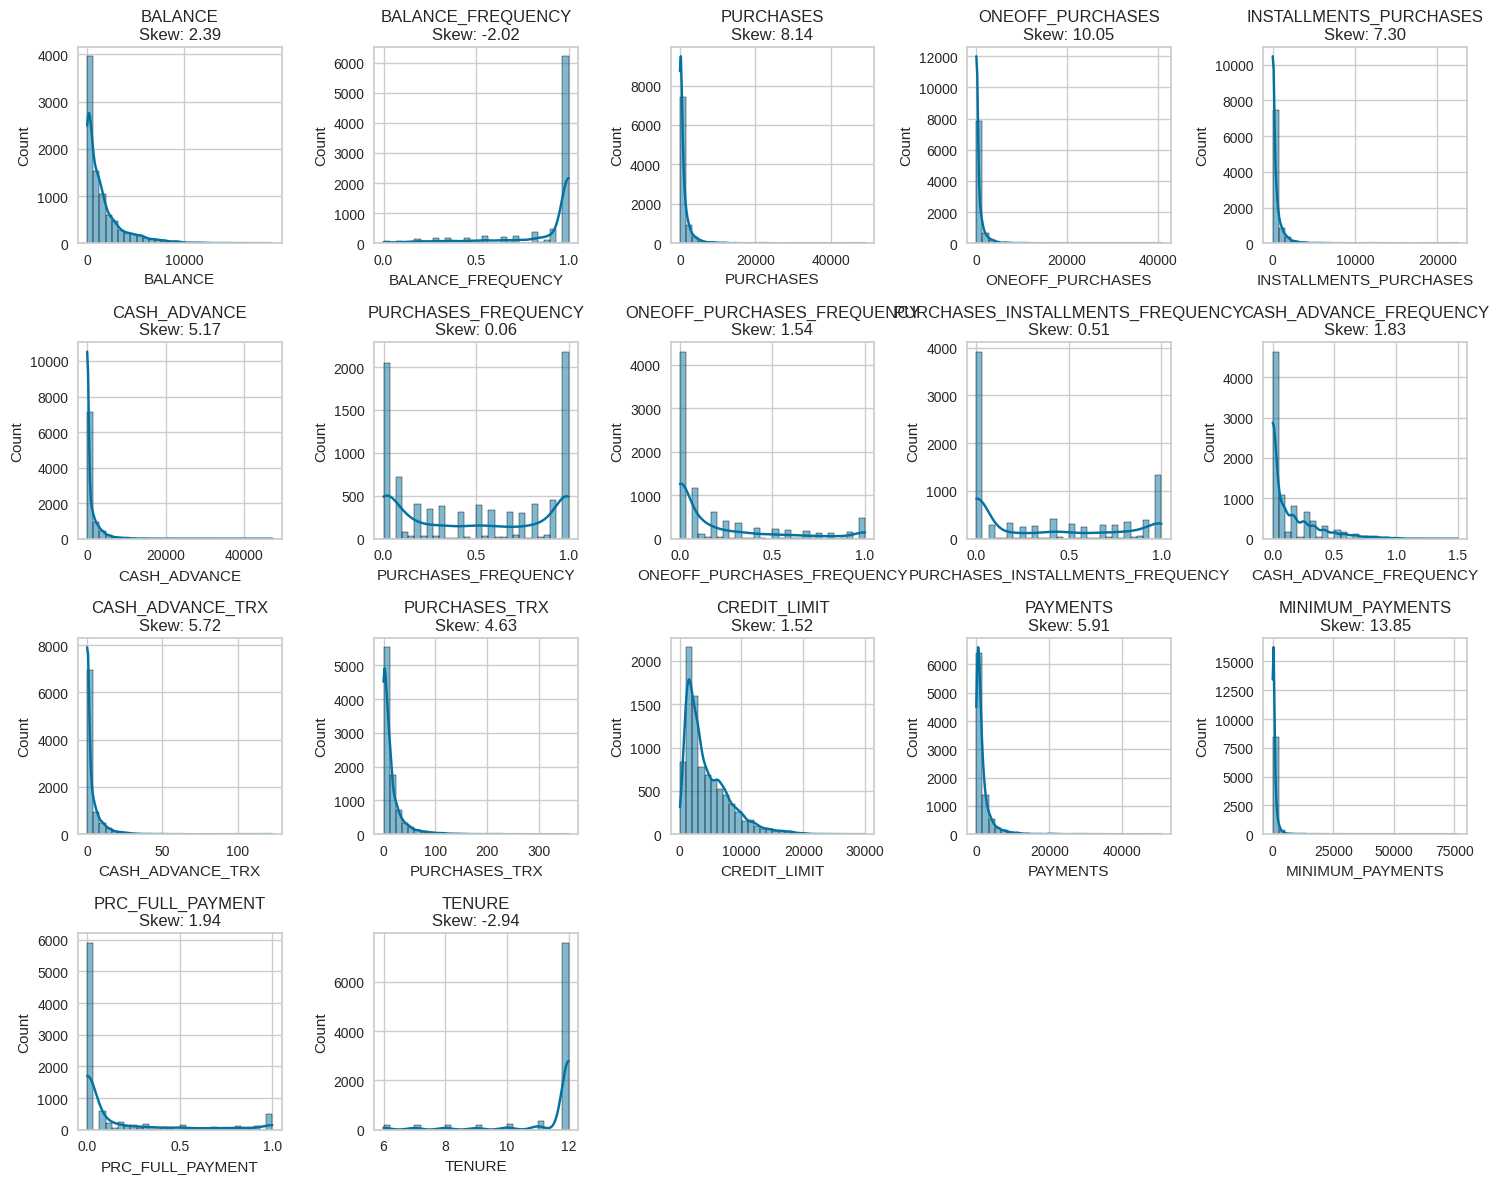

BALANCE                              2.393386
BALANCE_FREQUENCY                   -2.023266
PURCHASES                            8.144269
ONEOFF_PURCHASES                    10.045083
INSTALLMENTS_PURCHASES               7.299120
CASH_ADVANCE                         5.166609
PURCHASES_FREQUENCY                  0.060164
ONEOFF_PURCHASES_FREQUENCY           1.535613
PURCHASES_INSTALLMENTS_FREQUENCY     0.509201
CASH_ADVANCE_FREQUENCY               1.828686
CASH_ADVANCE_TRX                     5.721298
PURCHASES_TRX                        4.630655
CREDIT_LIMIT                         1.522636
PAYMENTS                             5.907620
MINIMUM_PAYMENTS                    13.852446
PRC_FULL_PAYMENT                     1.942820
TENURE                              -2.943017
dtype: float64

In [ ]:
# Menghitung nilai skew (kemiringan) dari setiap kolom sebelum transformasi log
original_skew_values = df.skew()

# Visualisasi persebaran data setiap fitur dan nilai skew nya
plt.figure(figsize=(15, 12))
for i, column in enumerate(df.columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[column], kde=True, bins=30)
    skew_value = original_skew_values[column]
    plt.title(f'{column}\nSkew: {skew_value:.2f}')
plt.tight_layout()
plt.show()

original_skew_values


Bisa dilihat hampir semua atribut memiliki nilai right-skewed yang tinggi. Berarti meng-handle outlier dengan transformasi log adalah pilihan yang tepat sekaligus untuk mengurangi nilai skew.

In [ ]:
# Terapkan transformasi log ke setiap kolom yang relevan kecuali PURCHASES_FREQUENCY, BALANCE_FREQUENCY, dan TENURE
df_log_selected = df.copy()

# Daftar kolom yang tidak akan di-transformasi log
columns_to_exclude = ['PURCHASES_FREQUENCY', 'BALANCE_FREQUENCY', 'TENURE']

# Terapkan log transformasi ke kolom yang relevan
for column in df_log_selected.columns:
    if column not in columns_to_exclude:
        df_log_selected[column] = np.log1p(df_log_selected[column])

# Tampilkan beberapa baris pertama untuk memastikan transformasi log
df_log_selected.head()


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,3.735304,0.818182,4.568506,0.000000,4.568506,0.000000,0.166667,0.000000,0.080042,0.000000,0.000000,1.098612,6.908755,5.312231,4.945277,0.000000,12
1,8.071989,0.909091,0.000000,0.000000,0.000000,8.770896,0.000000,0.000000,0.000000,0.223144,1.609438,0.000000,8.853808,8.319725,6.978531,0.200671,12
2,7.822504,1.000000,6.651791,6.651791,0.000000,0.000000,1.000000,0.693147,0.000000,0.000000,0.000000,2.564949,8.922792,6.434654,6.442994,0.000000,12
3,7.419183,0.636364,7.313220,7.313220,0.000000,5.331694,0.083333,0.080042,0.000000,0.080042,0.693147,0.693147,8.922792,0.000000,5.747301,0.000000,12
4,6.707735,1.000000,2.833213,2.833213,0.000000,0.000000,0.083333,0.080042,0.000000,0.000000,0.000000,0.693147,7.090910,6.521114,5.504483,0.000000,12


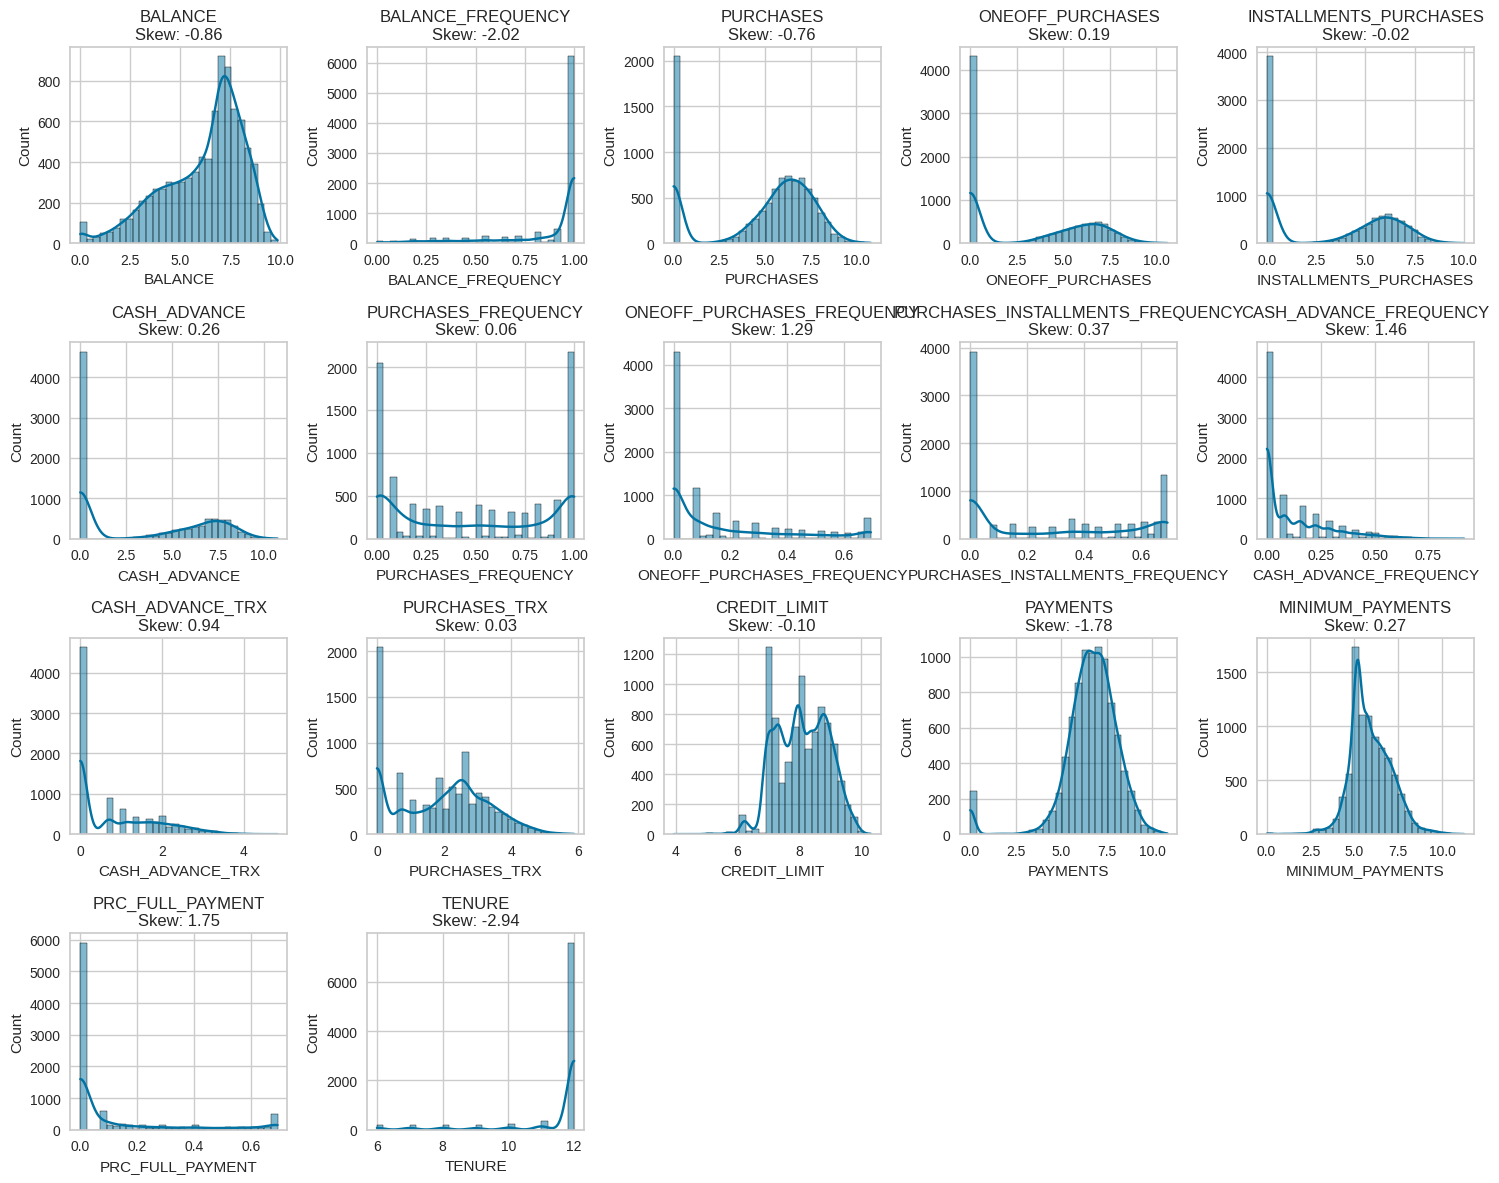

BALANCE                            -0.861021
BALANCE_FREQUENCY                  -2.023266
PURCHASES                          -0.764492
ONEOFF_PURCHASES                    0.185854
INSTALLMENTS_PURCHASES             -0.024981
CASH_ADVANCE                        0.262594
PURCHASES_FREQUENCY                 0.060164
ONEOFF_PURCHASES_FREQUENCY          1.290617
PURCHASES_INSTALLMENTS_FREQUENCY    0.373620
CASH_ADVANCE_FREQUENCY              1.455462
CASH_ADVANCE_TRX                    0.940131
PURCHASES_TRX                       0.032697
CREDIT_LIMIT                       -0.101408
PAYMENTS                           -1.778312
MINIMUM_PAYMENTS                    0.269703
PRC_FULL_PAYMENT                    1.746046
TENURE                             -2.943017
dtype: float64

In [ ]:
# Menghitung nilai skew (kemiringan) dari setiap kolom setelah transformasi log
log_skew_values = df_log_selected.skew()

# Visualisasi persebaran data setiap fitur dan nilai skew nya
plt.figure(figsize=(15, 12))
for i, column in enumerate(df_log_selected.columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(df_log_selected[column], kde=True, bins=30)
    skew_value = log_skew_values[column]
    plt.title(f'{column}\nSkew: {skew_value:.2f}')
plt.tight_layout()
plt.show()

log_skew_values


Setelah transformasi log, distribusi data jauh lebih normal dibanding sebelum di log.

In [ ]:
# Inisialisasi scaler
scaler = StandardScaler()

# Terapkan standarisasi pada semua kolom (termasuk yang tidak di-log transformasi)
df_standardized_all = pd.DataFrame(scaler.fit_transform(df_log_selected), columns=df_log_selected.columns)

# Periksa hasil standarisasi dengan melihat beberapa baris pertama
df_standardized_all.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-1.205218,-0.249434,-0.113532,-0.987090,0.394480,-0.930733,-0.806490,-0.732480,-0.674253,-0.724360,-0.810069,-0.579510,-1.447163,-0.824484,-0.829841,-0.556368,0.36068
1,0.948918,0.134325,-1.679855,-0.987090,-1.087454,1.528788,-1.221758,-0.732480,-0.958256,0.699592,0.784603,-1.379210,0.926060,1.065033,0.908184,0.391958,0.36068
2,0.824993,0.518084,0.600727,1.062022,-1.087454,-0.930733,1.269843,2.466762,-0.958256,-0.724360,-0.810069,0.487865,1.010229,-0.119300,0.450407,-0.556368,0.36068
3,0.624653,-1.016953,0.827499,1.265778,-1.087454,0.564372,-1.014125,-0.363042,-0.958256,-0.213583,-0.123281,-0.874655,1.010229,-4.161996,-0.144271,-0.556368,0.36068
4,0.271260,0.518084,-0.708481,-0.114307,-1.087454,-0.930733,-1.014125,-0.363042,-0.958256,-0.724360,-0.810069,-0.874655,-1.224909,-0.064979,-0.351833,-0.556368,0.36068


Data sudah terstandarisasi. Alasan mengapa perlu standarisasi dan kenapa menggunakan standard scaler:

Standarisasi data diperlukan karena algoritma clustering seperti K-Means dan agglomerative clustering yang kita gunakan pada lab ini sangat sensitif terhadap skala fitur. Jika fitur memiliki rentang yang berbeda beda, maka nanti fitur dengan rentang yang lebih besar akan mendominasi perhitungan jarak, sehingga dapat mengarahkan model ke solusi yang tidak optimal. Lalu kita gunakan Standard Scaler karena dia mengubah data sehingga setiap fitur memiliki mean nol dan standar deviasi satu, memastikan bahwa setiap fitur berkontribusi secara setara dalam perhitungan jarak. Kesimpulannya dengan meng-standarisasi data, kita dapat memastikan bahwa proses clustering menghasilkan grup/kluster yang lebih akurat dan representatif, karena setiap fitur diperlakukan dengan bobot yang setara dalam menentukan kluster.

Tanpa standarisasi, fitur dengan skala yang lebih besar dapat mempengaruhi perhitungan jarak ini secara tidak proporsional, sehingga menghasilkan hasil clustering yang bias dan tidak optimal

Karena semua fitur sudah dalam bentuk numerik, tidak ada yang kategorikal, maka tidak diperlukan encoding.

### Soal 2: K-Means Clustering

a) Buatlah dataset baru yang hanya memiliki fitur (kolom) pilihan. Pilih setidaknya 3 fitur, mencakup fitur numerik dan kategorikal, dan jelaskan alasan pemilihan fitur tersebut. Dataset ini akan digunakan untuk melakukan clustering

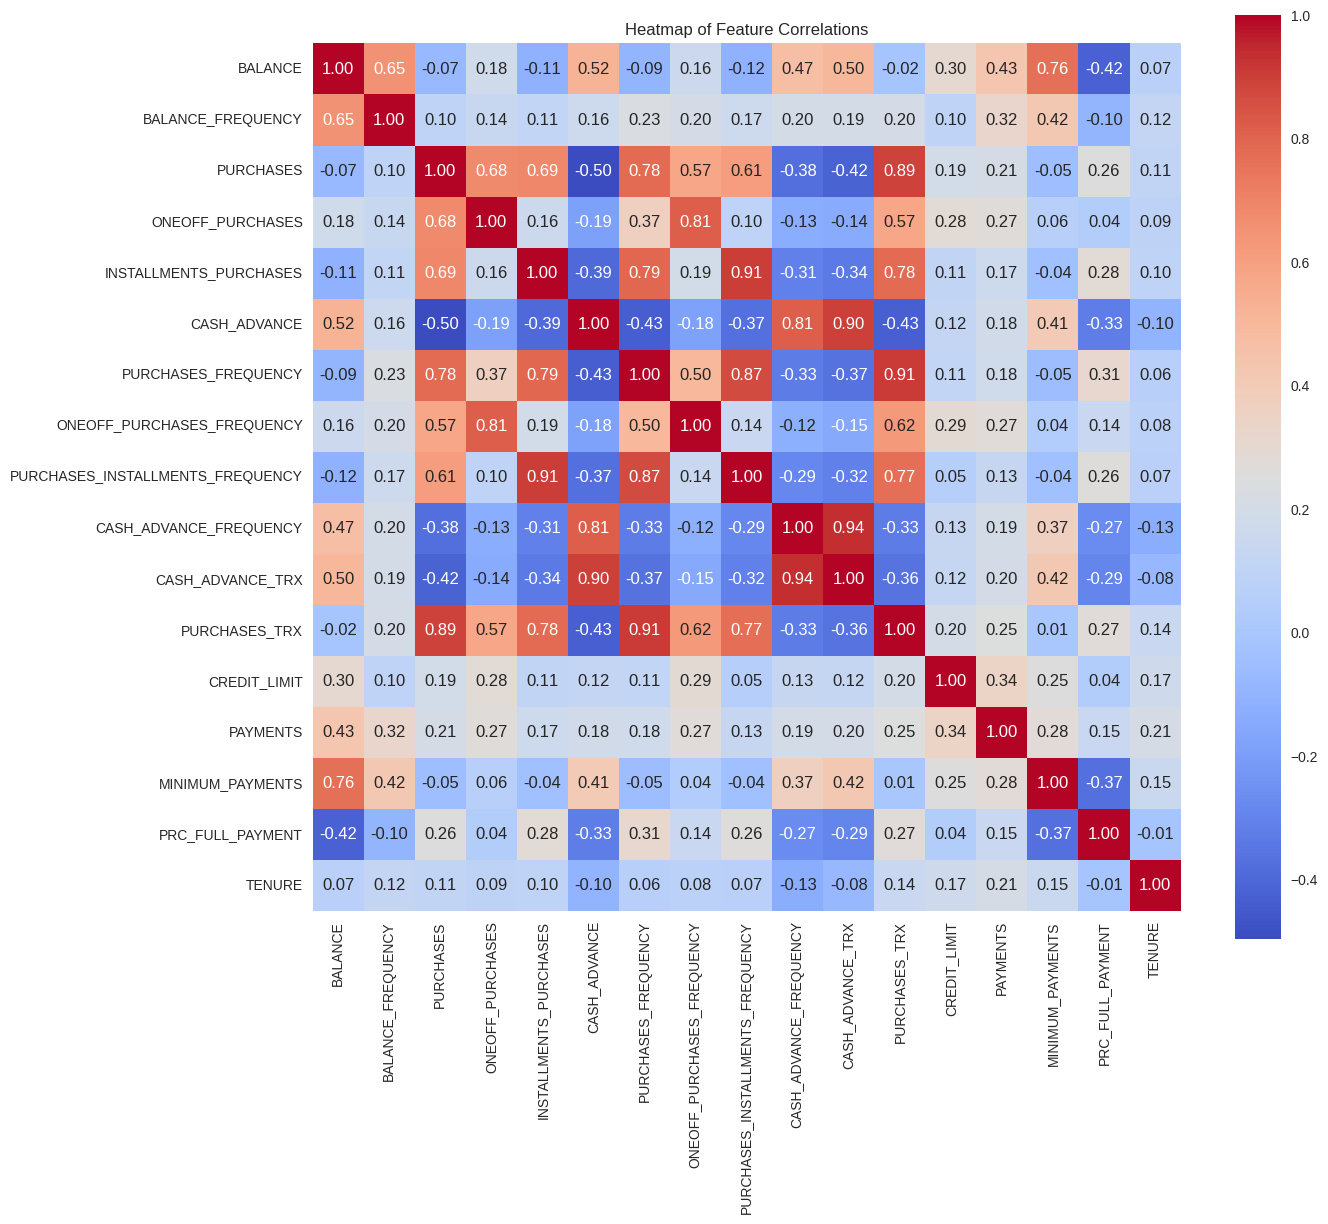

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Menghitung matriks korelasi dari semua fitur dalam dataset yang telah distandarisasi
correlation_matrix_all = df_standardized_all.corr()

# Membuat heatmap dari matriks korelasi
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_all, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Heatmap of Feature Correlations')
plt.show()


In [ ]:
selected_features = ['PURCHASES_FREQUENCY', 'CREDIT_LIMIT', 'PAYMENTS']

In [ ]:
# Menghitung varians dari fitur yang terpilih
selected_variances = variances[selected_features]

selected_variances

PURCHASES_FREQUENCY    1.000112
CREDIT_LIMIT           1.000112
PAYMENTS               1.000112
dtype: float64

In [ ]:
# Menghitung matriks korelasi dari fitur yang terpilih
selected_correlation_matrix = df_standardized_all[selected_features].corr()

selected_correlation_matrix

,PURCHASES_FREQUENCY,CREDIT_LIMIT,PAYMENTS
PURCHASES_FREQUENCY,1.000000,0.112644,0.175997
CREDIT_LIMIT,0.112644,1.000000,0.343597
PAYMENTS,0.175997,0.343597,1.000000


Alasan:

Saya memilih fitur PURCHASES_FREQUENCY, CREDIT_LIMIT, dan PAYMENTS untuk clustering karena mereka memiliki varians tinggi, menunjukkan variasi signifikan di antara customer, yang penting untuk membedakan kluster/grup antar customer.

- **Korelasi**:
    - Korelasi antara PURCHASES_FREQUENCY dan CREDIT_LIMIT yang **sangat lemah** (0,112644) menunjukkan bahwa fitur ini memberikan informasi unik yang tidak overlap dengan fitur lainnya.

    - Korelasi antara PURCHASES_FREQUENCY dan PAYMENTS yang **sangat lemah** (0,176997), menunjukkan bahwa fitur ini menambah dimensi baru untuk clustering.

    - Korelasi antara CREDIT_LIMIT dan PAYMENTS yang **sangat lemah** (0,343597), menunjukkan bahwa fitur ini memberikan informasi tambahan yang tidak overlap dengan fitur lainnya.

**Kesimpulan**

- **Varians Tinggi**: Semua fitur memiliki varians yang tinggi, menunjukkan variasi yang signifikan di antara customer, yang penting untuk membedakan kluster/grup antar customer.
- **Korelasi Rendah**: Fitur-fitur ini memiliki korelasi yang cukup rendah satu sama lain, sehingga memberikan informasi tambahan dan tidak saling overlap.
- **Relevansi untuk Clustering**: Fitur-fitur ini relevan untuk clustering karena mereka mencerminkan aspek yang berbeda dari perilaku customer: PURCHASES_FREQUENCY yang bisa memberikan informasi mengenai betapa seringnya customer belanja (berdasarkan frekuensinya), CREDIT_LIMIT yang bisa memberikan informasi mengenai batas limit kartu kredit customer, dan PAYMENTS yang memberikan informasi jumlah pembayaran yang dilakukan oleh pengguna, saya rasa ketiga atribut ini dapat membantu dalam mengidentifikasi kluster/grup pelanggan yang berbeda.

In [ ]:
df_selected = df_standardized_all[selected_features]

# Menampilkan beberapa baris pertama dari dataset baru
df_selected.head()

,PURCHASES_FREQUENCY,CREDIT_LIMIT,PAYMENTS
0,-0.806490,-1.447163,-0.824484
1,-1.221758,0.926060,1.065033
2,1.269843,1.010229,-0.119300
3,-1.014125,1.010229,-4.161996
4,-1.014125,-1.224909,-0.064979


b) Hitung dan visualisasikan nilai Silhouette Coefficient untuk dataset sebelumnya. Berikan interpretasi hasilnya

In [ ]:
# Menghitung Silhouette Coefficient untuk berbagai nilai k
for k in [2, 3, 4, 5]:
    # Mendefinisikan model K-Means dengan nilai k tertentu
    clusterer = KMeans(n_clusters=k, n_init=10, random_state=42)

    # Menghitung label klaster
    cluster_labels = clusterer.fit_predict(df_selected)

    # Menghitung silhouette_score untuk mengukur seberapa baik klaster yang terbentuk
    silhouette_avg = silhouette_score(df_selected, cluster_labels)
    print(f"Untuk k = {k}, rata-rata silhouette_coefficient adalah: {silhouette_avg}")

Untuk k = 2, rata-rata silhouette_coefficient adalah: 0.2960843459061839
Untuk k = 3, rata-rata silhouette_coefficient adalah: 0.2971428954977579
Untuk k = 4, rata-rata silhouette_coefficient adalah: 0.3305193785493394
Untuk k = 5, rata-rata silhouette_coefficient adalah: 0.3588844346403714


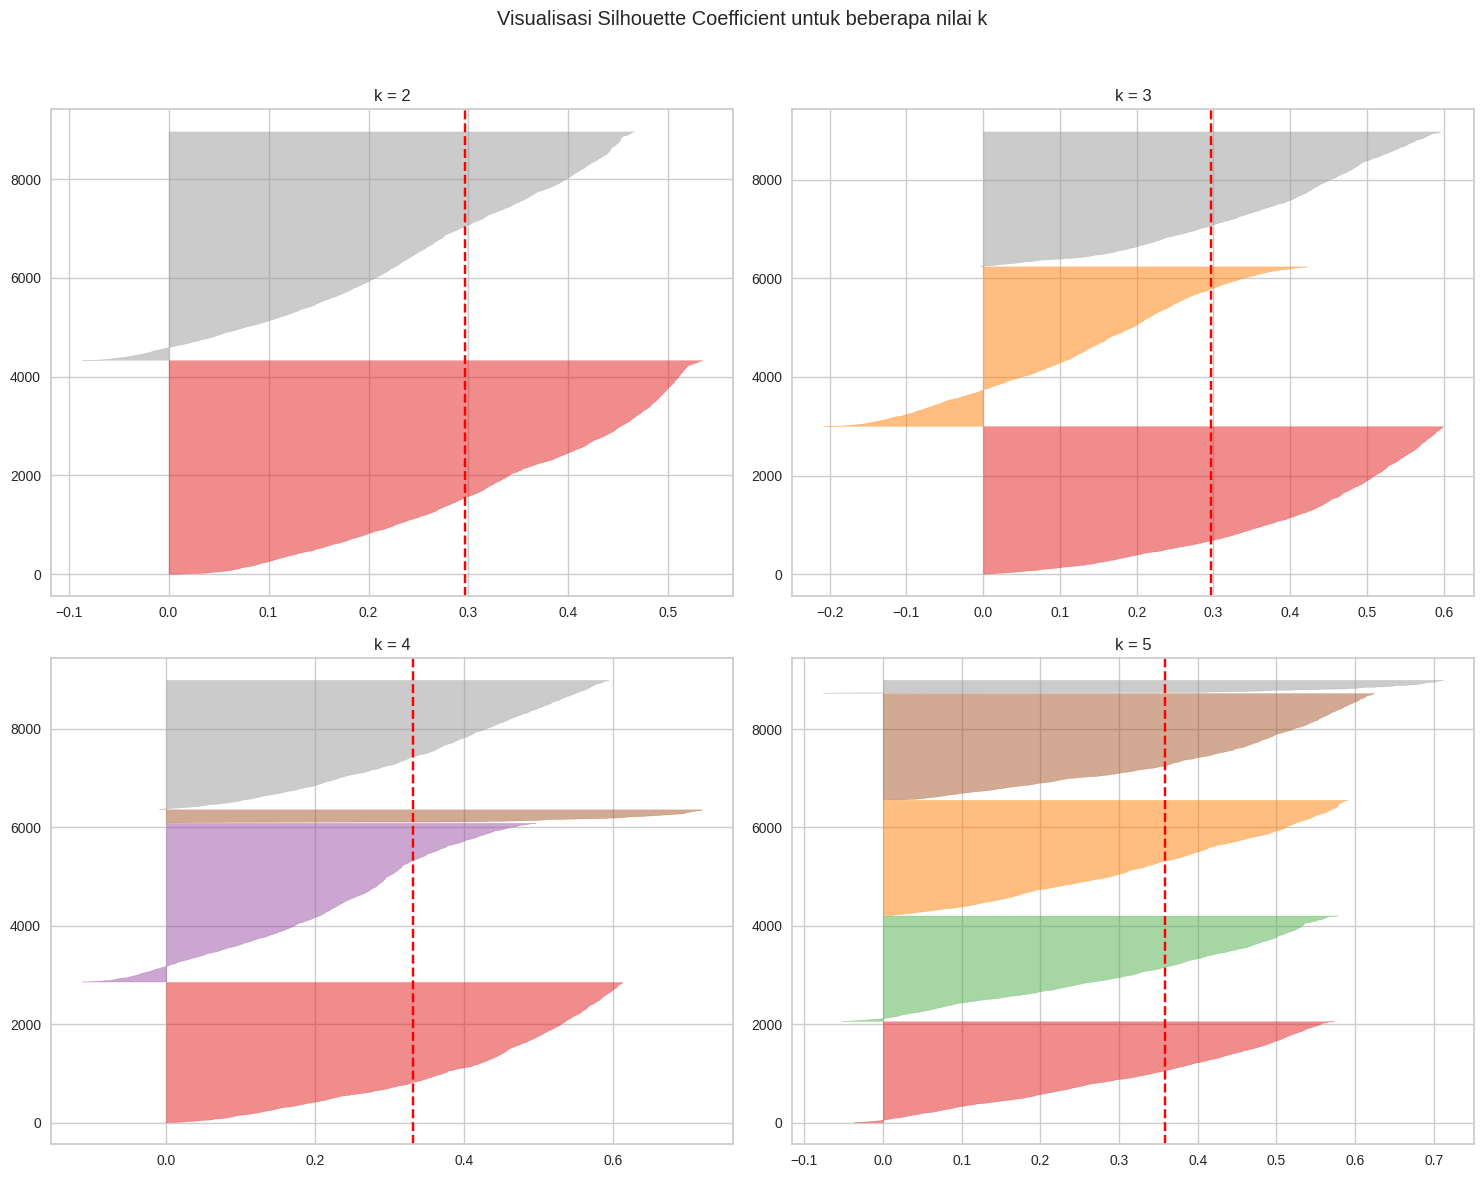

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt

# Memvisualisasikan silhouette
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Visualisasi Silhouette Coefficient untuk beberapa nilai k")

for i, k in enumerate([2, 3, 4, 5]):
    # Mendefinisikan model K-Means dengan nilai k tertentu
    clusterer = KMeans(n_clusters=k, n_init=10, random_state=42)

    # Memvisualisasikan densitas tiap klaster yang terbentuk
    q, mod = divmod(i, 2)
    ax[q][mod].set_title(f"k = {k}")
    visualizer = SilhouetteVisualizer(clusterer, ax=ax[q][mod])
    visualizer.fit(df_selected)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Untuk k = 2, rata-rata silhouette_coefficient adalah: 0.2960843459061839
Untuk k = 3, rata-rata silhouette_coefficient adalah: 0.2971428954977579
Untuk k = 4, rata-rata silhouette_coefficient adalah: 0.3305193785493394
Untuk k = 5, rata-rata silhouette_coefficient adalah: 0.3588844346403714

Hasil-nya menunjukkan bahwa nilai Silhouette Coefficient **tertinggi didapat saat jumlah klaster (k) adalah 5**, dengan rata-rata 0.3588. Ini berarti pembagian data ke dalam 5 klaster memberikan hasil klaster yang paling baik dan paling jelas.

Nilai Silhouette Coefficient untuk k=4, k=2, dan k=3 yang **lebih rendah dibandingkan k=5**, menunjukkan bahwa jumlah klaster tersebut kurang optimal. **Jadi, menggunakan 5 klaster merupakan pilihan terbaik untuk clustering pada dataset ini.**

c) Tampilkan visualisasi elbow method dengan suatu rentang nilai k (bisa berbeda) dan jelaskan perbandingannya dengan nilai Silhouette Coefficient yang didapatkan sebelumnya. Setelah itu, **pilih nilai k yang optimal** berdasarkan keduanya.

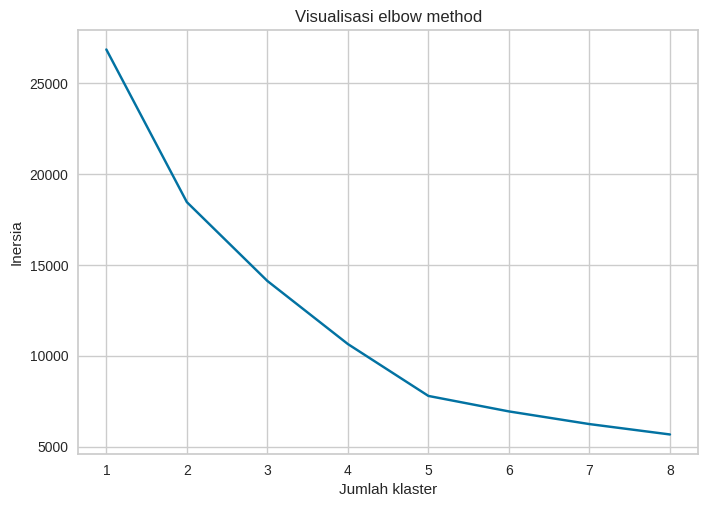

In [ ]:
# Memvisualisasikan elbow method
inertia = []
for cluster in range(1, 9):
    km = KMeans(n_clusters=cluster, n_init=10)
    km = km.fit(df_selected)
    inertia.append(km.inertia_)

plt.plot(range(1, 9), inertia, 'bx-')
plt.xlabel('Jumlah klaster')
plt.ylabel('Inersia')
plt.title('Visualisasi elbow method')
plt.show()

Berdasarkan hasil metrik Silhouette Coeff. dan Elbow Method, bisa dilihat bahwa data ini tidak menghasilkan klaster yang baik.

Nilai Silhouette Coeff untuk k = 2, k = 3, k = 4, dan k = 5 tidak jauh berbeda, merentang di angka 0,29 - 0,36.

Hal ini juga bisa dilihat dari plot Elbow Method di atas. Tidak ada inflection point yang perubahan gradiennya cukup drastis.

Walau begitu, saya tetap bisa menentukan Nilai K terbaik untuk dipilih. Yaiut, k = 5 karena nilai Silhouette Coeff untuk k = 2 adalah yang paling tinggi (bernilai 0.3588).

Ditambah lagi, jika dilihat pada visualisasi elbow method, terdapat perubahan gradien inersia yang lumayan drastis di antara keempat kandidat klaster.

d) Latih model KMeans dengan **nilai k yang sudah ditentukan** sebelumnya. Visualisasikan hasil clustering dan berikan interpretasi hasilnya.

In [ ]:
# Latih model sesuai jumlah klaster optimal
kmeans = KMeans(n_clusters=5, n_init=10)
clusteringdf = kmeans.fit_predict(df_selected)

In [ ]:
# Append hasil clustering ke dataframe
df_clustered = pd.DataFrame(df_selected.copy())
df_clustered['cluster'] = clusteringdf
df_clustered.head()

,PURCHASES_FREQUENCY,CREDIT_LIMIT,PAYMENTS,cluster
0,-0.806490,-1.447163,-0.824484,3
1,-1.221758,0.926060,1.065033,1
2,1.269843,1.010229,-0.119300,2
3,-1.014125,1.010229,-4.161996,4
4,-1.014125,-1.224909,-0.064979,3


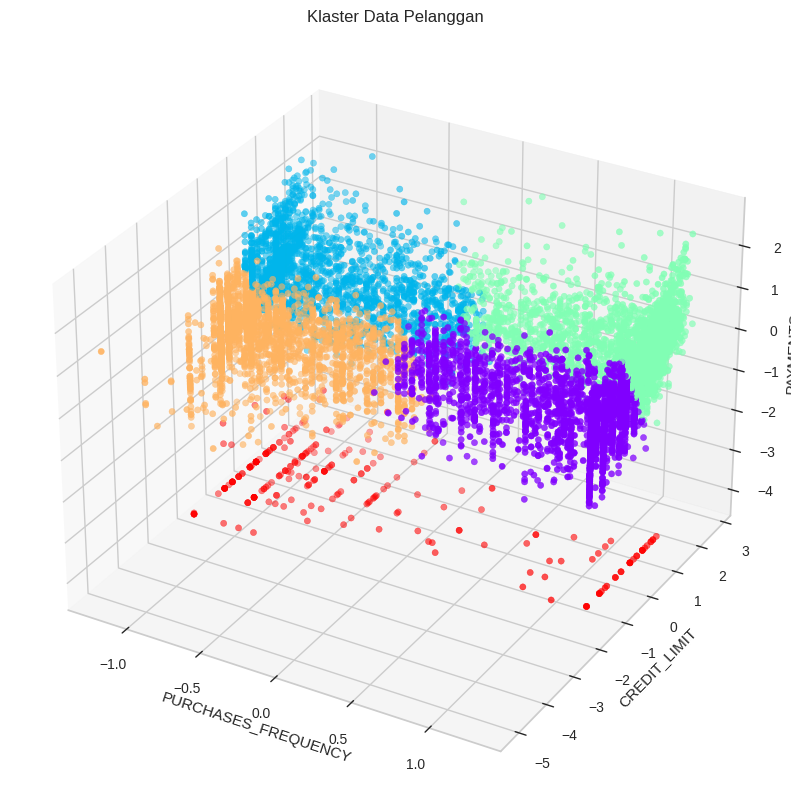

In [ ]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection="3d")

# Menyiapkan beberapa variabel yang diperlukan untuk visualisasi
x = df_clustered['PURCHASES_FREQUENCY']
y = df_clustered['CREDIT_LIMIT']
z = df_clustered['PAYMENTS']
cluster = df_clustered['cluster']

# Memvisualisasikan hasilnya
ax.scatter(x, y, z, c = cluster, cmap = "rainbow")
plt.title("Klaster Data Pelanggan")
plt.grid(False)
ax.set_xlabel('PURCHASES_FREQUENCY')
ax.set_ylabel('CREDIT_LIMIT')
ax.set_zlabel('PAYMENTS')

plt.show()

**INTERPRETASI:**
- **Klaster Biru Muda**:
    - **PURCHASES_FREQUENCY**: Rendah (sekitar -1 hingga 0.5).
    - **CREDIT_LIMIT**: Menengah hingga tinggi (sekitar 0 hingga 2).
    - **PAYMENTS**: Bervariasi, umumnya menengah (sekitar -2 hingga 0).
    - **Interpretasi**: Pelanggan dalam klaster ini cenderung memiliki batas kredit yang menengah hingga tinggi dengan frekuensi pembelian yang cukup jarang. Pembayaran mereka bervariasi, menunjukkan perilaku pembayaran yang beragam.
- **Klaster Hijau**:
    - **PURCHASES_FREQUENCY**: Tinggi (sekitar 0 hingga 1).
    - **CREDIT_LIMIT**: Tinggi (sekitar 1 hingga 3).
    - **PAYMENTS**: Bervariasi (sekitar -2 hingga 2).
    - **Interpretasi**: Pelanggan dalam klaster ini memiliki pembayaran mereka bervariasi dengan frekuensi pembelian yang sering. Batas kredit mereka juga tinggi, sesuai dengan perilaku pembelian mereka.
- **Klaster Oren**:
    - **PURCHASES_FREQUENCY**: Rendah (sekitar -1 hingga 0.5).
    - **CREDIT_LIMIT**: Menengah ke rendah (sekitar -2 hingga 0).
    - **PAYMENTS**: Bervariasi tapi cenderung ke rendah (sekitar -3 hingga 0).
    - **Interpretasi**: Pelanggan dalam klaster ini memiliki batas kredit menengah ke rendah dengan frekuensi pembelian yang bervariasi. Pembayaran mereka umumnya menengah ke rendah, menunjukkan perilaku pembayaran yang moderat.
- **Klaster Ungu**:
    - **PURCHASES_FREQUENCY**: Tinggi (sekitar 0 hingga 1).
    - **CREDIT_LIMIT**: Menengah ke rendah (sekitar -2 hingga 0).
    - **PAYMENTS**: Bervariasi tapi cenderung ke rendah (sekitar -3 hingga 0).
    - **Interpretasi**: Pelanggan dalam klaster ini memiliki batas kredit yang rendah dengan frekuensi pembelian yang lumayan sering. Pembayaran mereka bervariasi.
- **Klaster Merah**:
    - **PURCHASES_FREQUENCY**: Sangat beragam (tersebar di berbagai titik).
    - **CREDIT_LIMIT**: Sangat beragam (sekitar -2 hingga 2).
    - **PAYMENTS**: Sangat rendah (sekitar -4 hingga -3).
    - **Interpretasi**: Pelanggan dalam klaster ini memiliki batas kredit dan frekuensi pembelian yang beragam. Pembayaran mereka sangat rendah, menunjukkan bahwa mereka mungkin jarang melakukan transaksi yang besar.

Pola yang bisa dilihat dari hasil visualisasi ini adalah jika dilihat dari suduh pandang **PURCHASES_FREQUENCY:** klaster oren selalu berada di kiri klaster ungu & klaster biru selalu berada di kiri klaster hijau. Hal itu berarti **PURCHASES_FREQUENCY** menjadi pemisah utama antara kluster oren dengan ungu & klaster biru dengan klaster hijau.

Jika dilihat dari suduh pandang **CREDIT_LIMIT:** klaster ungu selalu berada di kiri klaster hijau & klaster oren selalu berada di kiri klaster biru. Hal itu berarti **PURCHASES_FREQUENCY** menjadi pemisah utama antara kluster ungu dengan hijau & klaster oren dengan klaster biru.

Jika dilihat dari suduh pandang **PAYMENTS:** klaster merah selalu terpisah diantara ke-4 klaster lainnya. Hal itu berarti **PAYMENTS** menjadi pemisah utama antara klaster dengan ke-4 klaster lainnya.

Kluster-kluster disini tampak tersegmentasi dengan baik di ruang data.

### Soal 3: Hierarchical Clustering

a) Latih model Agglomerative clustering sementara tanpa menspesifikasikan jumlah cluster

In [ ]:
# Membuat model sementara untuk divisualisasikan
agglomerative  = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
cluster_assignment = agglomerative.fit(df_selected)

# Menampilkan label klaster tiap data points
cluster_assignment.labels_

array([8325, 7215, 6195, ...,    5,    2,    0])

b) Tampilkan dendogram dan berikan interpretasinya. Selanjutnya, tentukan jumlah klaster (nilai k) yang optimal

In [ ]:
# Fungsi untuk menampilkan dendogram
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot dendogram yang dihasilkan
    shc.dendrogram(linkage_matrix, **kwargs)

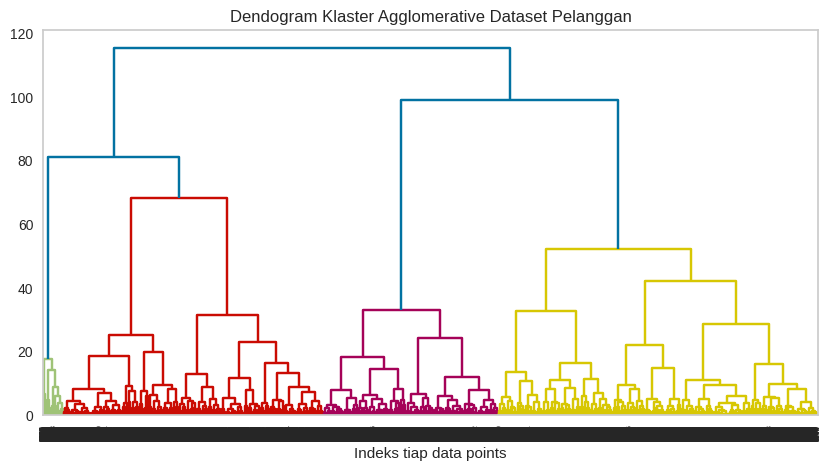

In [ ]:
plt.figure(figsize=(10, 5))
plt.grid(False)
plot_dendrogram(agglomerative, truncate_mode=None)
plt.title("Dendogram Klaster Agglomerative Dataset Pelanggan")
plt.xlabel("Indeks tiap data points")
plt.show()

**INTERPRETASI:**

Terbentuk 5 klaster:
1. **Klaster 1 (Merah)**:
    - **Panjang Garis Horizontal**:
        - Beberapa garis horizontal panjang di sekitar ketinggian 60-80 menunjukkan bahwa klaster ini digabungkan dari sub-kluster yang cukup berbeda satu sama lain.
        - Penggabungan ini terjadi pada tahap yang lebih tinggi dalam hierarki.
    - **Interpretasi**:
        - Klaster merah mungkin terdiri dari customer dengan karakteristik yang beragam.
2. **Klaster 2 (Ungu)**:
    - **Panjang Garis Horizontal**:
        - Garis horizontal relatif pendek pada ketinggian 20-40 menunjukkan bahwa sub-kluster dalam klaster ungu memiliki karakteristik yang lebih mirip satu sama lain.
    - **Interpretasi**:
        - customer dalam klaster ini kemungkinan memiliki karakteristik yang lebih seragam.
3. **Klaster 3 (Kuning)**:
    - **Panjang Garis Horizontal**:
        - Terdapat beberapa garis horizontal panjang di sekitar ketinggian 40-60.
        - Penggabungan ini juga terjadi pada tahap yang lumayan tinggi, menunjukkan adanya perbedaan antara sub-kluster.
    - **Interpretasi**:
        - Klaster kuning mungkin terdiri dari customer dengan karakteristik yang lumayan beragam.
4. **Klaster 4 (Hijau)**:
    - **Panjang Garis Horizontal**:
        - Garis horizontal pendek pada ketinggian rendah (0-20) menunjukkan bahwa sub-kluster dalam klaster hijau sangat mirip satu sama lain.
    - **Interpretasi**:
        - Customer dalam klaster ini memiliki karakteristik yang sangat mirip atau bahkan identik.
5. **Klaster 5 (Biru)**:
    - **Panjang Garis Horizontal**:
        - Garis horizontal dengan panjang menengah pada ketinggian 20-40 menunjukkan penggabungan sub-kluster dengan perbedaan yang cukup signifikan.
    - **Interpretasi**:
        - Klaster biru terdiri dari sub-kluster yang mirip namun tetap memiliki beberapa variasi internal yang signifikan.

Pada dendrogram ini. jika kita memotong pada sekitar ketinggian 70-80, kita dapat melihat bahwa dendrogram terbagi menjadi beberapa klaster:

- Klaster hijau di sebelah kiri
- Klaster merah di tengah kiri
- Klaster ungu di tengah
- Klaster kuning di kanan

Ini menunjukkan bahwa jumlah klaster yang optimal bisa jadi sekitar 4, karena masing-masing warna mengindikasikan kelompok utama.

c) Latih model agglomerative clustering dengan nilai k yang sudah ditentukan sebelumnya. Visualisasikan hasil clustering dan bandingkan hasilnya dengan hasil clustering KMeans.

In [ ]:
# Definisikan model dengan hasil visualisasi sebelumnya
agglomerative = AgglomerativeClustering(n_clusters=5)
cluster_assignment2 = agglomerative.fit_predict(df_selected)

In [ ]:
# Append hasil clustering ke dataframe
df_with_clusters_agg2 = pd.DataFrame(df_selected.copy())
df_with_clusters_agg2['cluster'] = cluster_assignment2
df_with_clusters_agg2.head()

,PURCHASES_FREQUENCY,CREDIT_LIMIT,PAYMENTS,cluster
0,-0.806490,-1.447163,-0.824484,4
1,-1.221758,0.926060,1.065033,0
2,1.269843,1.010229,-0.119300,2
3,-1.014125,1.010229,-4.161996,3
4,-1.014125,-1.224909,-0.064979,4


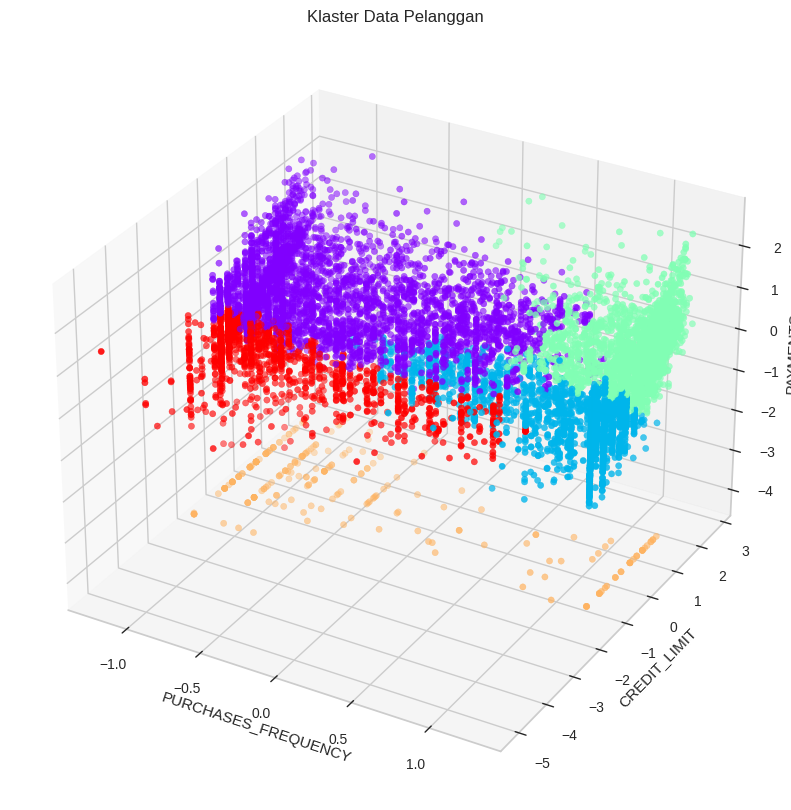

In [ ]:
# Melakukan visualisasi
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection="3d")

x = df_with_clusters_agg2['PURCHASES_FREQUENCY']
y = df_with_clusters_agg2['CREDIT_LIMIT']
z = df_with_clusters_agg2['PAYMENTS']
cluster = df_with_clusters_agg2['cluster']

ax.scatter(x, y, z, c = cluster, cmap = "rainbow")
plt.title("Klaster Data Pelanggan")
plt.grid(False)
ax.set_xlabel('PURCHASES_FREQUENCY')
ax.set_ylabel('CREDIT_LIMIT')
ax.set_zlabel('PAYMENTS')

plt.show()

**INTERPRETASI:**
Jika dibandingkan dengan visualisasi dengan agglomerative dengan k means, disini agglomerative clustering menghasilkan kluster yang lebih padat dan tersebar. Sedangkan K-means menghasilkan kluster yang lebih seragam dan tersegmentasi dengan baik.

Distribusi disini cenderung tersebar tidak merata. Beberapa kluster tampak sangat padat, sedangkan yang lain lebih tersebar.
1. **Karakteristik Masing-masing Kluster**:
    - **Kluster Ungu**:
        - Terletak di bagian tengah atas grafik dan Memiliki distribusi yang cukup padat. Tampaknya memiliki jumlah titik yang paling banyak diantara klaster yang lain.
    - **Kluster Merah**:
        - Terletak di bagian tengah bawah grafik. Tampak lebih tersebar dibandingkan kluster hijau dan biru.
    - **Kluster Hijau**:
        - Terletak di bagian kanan atas grafik. Memiliki distribusi yang relatif lebih merata dan berkumpul di satu area.
    - **Kluster Biru**:
        - Juga terletak di bagian kanan atas grafik, berdekatan dengan kluster hijau muda dan tampak sedikit tersebar.
    - **Kluster Oren**:
        - Terletak lebih tersebar di seluruh grafik. Customer dalam kluster ini menunjukkan variasi besar dalam purchases frequency dan credit limit.

Agglomerative clustering tampaknya lebih sensitif terhadap kepadatan lokal data. Kluster yang padat (seperti kluster ungu) menunjukkan bahwa ada banyak customer dengan karakteristik yang sangat mirip, sedangkan kluster yang lebih tersebar (seperti kluster merah dan oren) menunjukkan variasi yang lebih besar di antara customer.


### Soal 4: Latihan Teoretis
a) Jelaskan 2 metrik evaluasi yang digunakan dalam lab ini!
Pada lab ini kita menggunakan 2 metrik, yaitu **Silhouette Coefficient** dan **Elbow Method.**

1. **Silhouette Coefficient**

Metrik ini mengukur seberapa baik setiap titik data ter-klaster ke dalam klusternya. Metrik ini menggabungkan informasi tentang kohesi (seberapa dekat titik data dengan titik-titik lain dalam klusternya sendiri) dan separasi (seberapa jauh titik data dari titik-titik dalam kluster lain) dari titik data tersebut.

Koefisien ini berkisar dari -1 hingga 1, di mana nilai yang mendekati 1 menunjukkan titik data yang terklaster dengan baik, nilai yang mendekati 0 menunjukkan kluster yang saling overlap, dan nilai yang mendekati -1 menunjukkan titik data yang salah klaster.

Skor Silhouette Coefficient yang lebih tinggi menunjukkan bahwa titik-titik data terklaster dengan baik, dengan pemisahan yang jelas antara kluster dan kohesi yang erat dalam setiap kluster. Sebaliknya, skor Silhouette Coefficient yang lebih rendah menunjukkan bahwa pengelompokan mungkin kurang akurat, dengan kluster yang saling tumpang tindih atau titik-titik yang tidak terklaster dengan baik ke dalam klusternya masing-masing.

2. **Elbow Method**

Metode elbow adalah teknik yang digunakan untuk menentukan jumlah kluster optimal dalam analisis clustering. Metode ini melibatkan plotting jumlah kluster melawan inersia (total jarak antar semua titik ke titik pusat kluster). Tujuannya adalah untuk menemukan titik di mana penurunan inersia mulai melambat, yang terlihat seperti "siku" pada grafik, atau titik elbow.

Kenapa kita memilih titik dengan gradien inersia yang paling drastis (titik elbow) dan bukan yang tertinggi? Karena:

- **Inersia adalah** total jarak antar semua titik ke titik pusat kluster. Semakin tinggi nilai inersia, semakin buruk kluster tersebut, karena berarti similarity-nya kecil dan jarak antar titiknya jauh.
- Jika kita memilih titik dengan inersia tertinggi, itu menunjukkan kluster yang sangat buruk.
- Sebaliknya, memilih titik dengan inersia terkecil berarti terlalu banyak kluster yang mungkin tidak efisien.

Dengan memilih titik elbow, kita mendapatkan jumlah kluster yang paling efektif. Setelah titik elbow, penurunan inersia biasanya sedikit, sehingga tidak berarti semakin banyak kluster semakin banyak informasi yang kita dapatkan. Titik elbow menunjukkan keseimbangan terbaik antara jumlah kluster dan efisiensi clustering.

b) Jelaskan cara menghitung intra-cluster similarity dan inter-cluster dissimilarity!

Penghitungan intra-cluster similarity dan inter-cluster dissimilarity ini adalah perhitungan yang digunakan dalam menghitung Silhouette Score. Silhouette Score menggabungkan kedua metrik ini untuk mengevaluasi seberapa baik pengelompokan (clustering) dilakukan.

**Intra-cluster similarity** mengukur sejauh mana titik-titik dalam kluster tersebut saling dekat. Perhitungan ini mencari tahu seberapa mirip titik tersebut dengan titik-titik lain di kluster yang sama. Rumusnya adalah:
$$
a(i) = \frac{1}{|A| - 1} \sum_{j \in A, j \neq i} d(i, j)
$$
Di mana $d(i, j)$ adalah jarak antara titik $i$ dan $j$. A adalah kluster dimana titik $i$ berada.

**Inter-cluster dissimilarity** mengukur seberapa berbeda atau terpisah satu kluster dengan kluster lainnya. Nilai $b(i)$ adalah rata-rata jarak terdekat dari titik $i$ ke titik-titik dalam kluster lain $B$:
$$
b(i) = \min_{B \neq A} \left( \frac{1}{|B|} \sum_{j \in B} d(i, j) \right)
$$

**Silhouette Score (s(i)) kemudian dihitung dengan rumus:**

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

Nilai mendekati 1 menunjukkan bahwa titik tersebut berada di kluster yang benar.

Nilai mendekati 0 menunjukkan bahwa titik tersebut berada di batas antara dua kluster.

Nilai mendekati -1 menunjukkan bahwa titik tersebut mungkin salah diklasifikasikan.


c) K-Means adalah algoritma yang bekerja baik untuk data globular, tetapi tidak untuk data yang memiliki klaster sembarang. Apa yang akan terjadi apabila K-Means dipakai untuk kasus tersebut?
Algoritma K-Means kurang cocok untuk data pengelompokan yang tidak bersifat globular karena algoritma ini mengasumsikan kluster berbentuk geometri bola dan memiliki varians yang sama.

**1. Asumsi Bentuk Kluster**

K-Means mengasumsikan bahwa setiap kluster memiliki bentuk yang bulat (spherical) atau globular dan ukuran yang kurang lebih sama. Dalam prosesnya, K-Means meminimalkan inersia, yaitu jumlah kuadrat jarak antara setiap titik data dalam kluster dengan centroid terdekat. Namun, jika data memiliki kluster dengan bentuk yang tidak bulat atau non-globular, seperti bentuk bulan sabit, spiral, atau bentuk kompleks lainnya, K-Means tidak akan efektif dalam mengelompokkan data dengan benar. Kluster dengan bentuk kompleks akan terpotong-potong secara tidak tepat, mengakibatkan hasil pengelompokan yang tidak representatif terhadap struktur data yang sebenarnya.

**2. Varians yang Berbeda**

K-Means mengasumsikan bahwa semua kluster memiliki varians yang sama. Artinya, kepadatan titik data dalam setiap kluster dianggap seragam. Jika data memiliki kluster dengan kepadatan yang berbeda (misalnya, satu kluster sangat padat sementara kluster lain lebih renggang), K-Means tidak akan mampu menangkap perbedaan ini dengan baik. Kluster yang lebih padat mungkin akan terfragmentasi, sementara kluster yang lebih renggang mungkin akan digabung dengan titik data yang seharusnya berada di kluster yang berbeda.

**Yang terjadi adalah:**

hasil pengelompokan akan menjadi tidak akurat dan tidak representatif terhadap struktur data yang sebenarnya. Kluster dengan bentuk kompleks dapat terpotong-potong secara tidak tepat, kluster dengan kepadatan berbeda mungkin tidak terdeteksi dengan baik, dan hasil clustering akan sangat bergantung pada inisialisasi pusat kluster awal. Akibatnya, banyak titik data yang mungkin salah diklasifikasikan, mengurangi kualitas hasil pengelompokan.

**3. Sensitivitas terhadap Inisialisasi**

K-Means sangat sensitif terhadap pemilihan pusat kluster awal (centroids). Inisialisasi yang berbeda dapat menghasilkan hasil pengelompokan yang berbeda. Jika inisialisasi awal tidak representatif, algoritma dapat terkunci pada solusi yang tidak optimal.

d) Jika kita menjalankan `sklearn.cluster.KMeans` berulang kali, apakah akan selalu didapatkan hasil yang sama?

Jika kita menjalankannya berulang kali dengan pengaturan default, maka hasilnya mungkin tidak selalu sama. Ini karena pusat kluster (centroids) dipilih secara acak setiap kali algoritma dijalankan, yang bisa menghasilkan hasil yang berbeda setiap kali.

Tapi, kalau kita menetapkan parameter random_state ke angka tertentu (misalnya, random_state=42), maka inisialisasi acaknya akan tetap sama, dan hasilnya akan konsisten setiap kali kita menjalankan KMeans. Jadi, kalau kita mengatur random_state, maka kita memastikan bahwa pusat kluster akan selalu diinisialisasi dengan cara yang sama setiap kali algoritma dijalankan, sehingga hasil clustering juga akan tetap sama.